# BPNST

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
import seaborn as sns
sns.set()

In [3]:
df = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/BPNST_features.xlsx")

In [4]:
reduced_features = pd.read_excel("/Users/samwwong/Desktop/Michael Zhang/LASSO_reduced_features.xlsx")

In [5]:
reduced_features_list = reduced_features.loc[reduced_features['BPNST'].isnull() == False, ['BPNST']].values.tolist()

In [6]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [7]:
reduced_features_list

['nf1',
 'original_shape_SphericalDisproportion',
 'log-sigma-1-mm-3D_firstorder_Kurtosis',
 'wavelet-HLL_firstorder_Kurtosis']

In [8]:
target = df["subtype"]

In [9]:
target.value_counts()

Schwannoma      107
Neurofibroma     59
Name: subtype, dtype: int64

In [10]:
#Marking 0 as Neurofibroma and 1 as Schwannoma
#target = target.map(dict(Neurofibroma = 1, Schwannoma = 0))
target = target.map(dict(Schwannoma = 1, Neurofibroma = 0))

In [11]:
features_after_lasso = df[reduced_features_list]

In [12]:
nf1_binarized = features_after_lasso['nf1'].map(dict(Y = 1, N = 0)).to_numpy()
features_after_lasso['nf1'] = nf1_binarized

<ipython-input-12-888c4ca0a9a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_after_lasso['nf1'] = nf1_binarized


In [13]:
features_after_lasso

,nf1,original_shape_SphericalDisproportion,log-sigma-1-mm-3D_firstorder_Kurtosis,wavelet-HLL_firstorder_Kurtosis
0,1,1.669953,3.866619,5.696827
1,0,1.441481,2.533610,2.872349
2,0,1.770582,3.506580,5.363123
3,0,1.352049,5.878728,8.242469
4,1,1.621691,7.179669,21.385588
...,...,...,...,...
161,0,1.454079,3.041772,3.780123
162,0,1.229792,2.305763,6.236577
163,0,1.329895,3.706818,4.485687
164,0,1.234792,3.194941,9.324928


In [14]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [15]:
y_train.value_counts()

1    74
0    50
Name: subtype, dtype: int64

In [16]:
y_test.value_counts()

1    33
0     9
Name: subtype, dtype: int64

# Standardizing Features

In [17]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [18]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [19]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [20]:
def create_ci(bootstrapped_scores, name):
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
    print("95% Confidence interval for the {} score: [{:0.3f} - {:0.3}]".format(name, 
    confidence_lower, confidence_upper))

In [21]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TN / (TN + FP)        

# SVM

### Grid Search for Hyperparameters

In [22]:
svm_model = svm.SVC()
grid_param = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']
}

svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [23]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             scoring='accuracy')

In [24]:
print(svm_grid.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


### Model Performance

In [25]:
svm_model = svm.SVC(C = 1, gamma = 0.1, kernel = 'rbf', probability = True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [26]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.9285714285714286
Specificity Score: 0.7777777777777778
Precision: 0.9411764705882353
Recall: 0.9696969696969697
F1 Score: 0.955223880597015


In [27]:
svm_probs = svm_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, svm_probs)
auc = roc_auc_score(y_test, svm_probs)
print("AUC: " + str(auc))

AUC: 0.8249158249158249


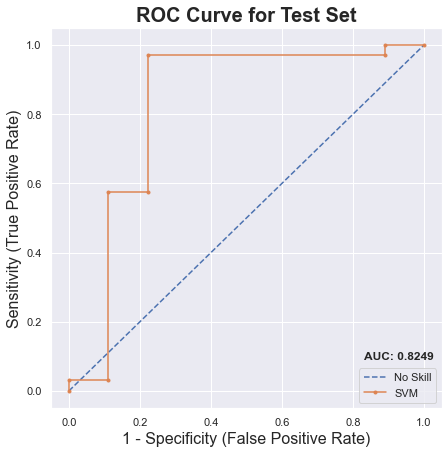

In [28]:
plt.figure(figsize=(7, 7))


ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

plt.legend(loc='lower right')
plt.title('ROC Curve for Test Set', fontsize=20, fontweight="semibold")
short_auc = round(auc,4)
plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=12, fontweight="semibold")
    
plt.show()

In [29]:
sns.reset_orig()

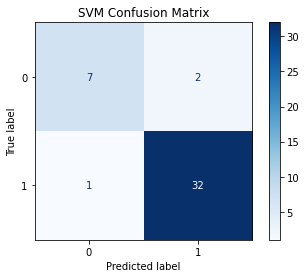

In [30]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [31]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(svm_probs), len(svm_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], svm_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

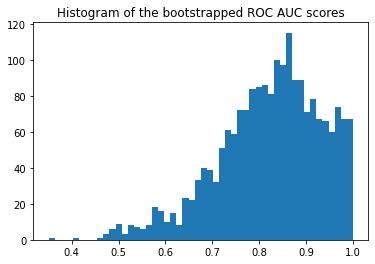

In [32]:
plt.hist(bootstrapped_auc_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [33]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.567 - 1.0]
95% Confidence interval for the Accuracy score: [0.833 - 1.0]
95% Confidence interval for the Specificity score: [0.444 - 1.0]
95% Confidence interval for the Precision score: [0.848 - 1.0]
95% Confidence interval for the Recall score: [0.900 - 1.0]
95% Confidence interval for the F1 score: [0.893 - 1.0]


# Logistic Regression

### Grid Search for Hyperparameters

In [34]:
lr_model = LogisticRegression()
grid_param = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [35]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='accuracy')

In [36]:
print(lr_grid.best_params_)

{'C': 0.1, 'penalty': 'l2'}


### Model Performance

In [37]:
lr_model = LogisticRegression(penalty = 'l2', C = 0.1)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [38]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.9285714285714286
Specificity Score: 0.7777777777777778
Precision: 0.9411764705882353
Recall: 0.9696969696969697
F1 Score: 0.955223880597015


In [39]:
lr_probs = lr_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
auc = roc_auc_score(y_test, lr_probs)
print("AUC: " + str(auc))

AUC: 0.9225589225589226


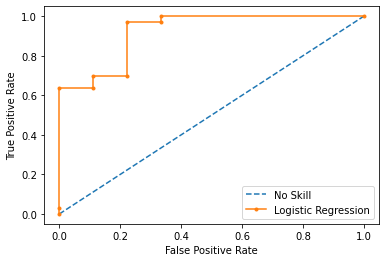

In [40]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

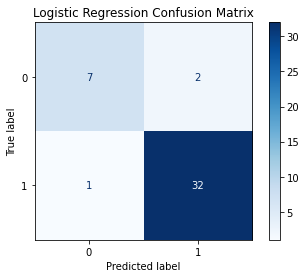

In [41]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [42]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(lr_probs), len(lr_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], lr_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [43]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.798 - 1.0]
95% Confidence interval for the Accuracy score: [0.833 - 1.0]
95% Confidence interval for the Specificity score: [0.444 - 1.0]
95% Confidence interval for the Precision score: [0.848 - 1.0]
95% Confidence interval for the Recall score: [0.900 - 1.0]
95% Confidence interval for the F1 score: [0.893 - 1.0]


In [44]:
sns.set()

In [45]:
feature_labels_dict = {'nf1': 'NF1', 
                      'original_shape_SphericalDisproportion': 'Original Shape Spherical Dispropotion',
                          'log-sigma-1-mm-3D_firstorder_Kurtosis': 'Log Sigma 1mm 3D Kurtosis (1st Order)',
                          'wavelet-HLL_firstorder_Kurtosis': 'Wavelet HLL Kurtosis (1st Order)'}

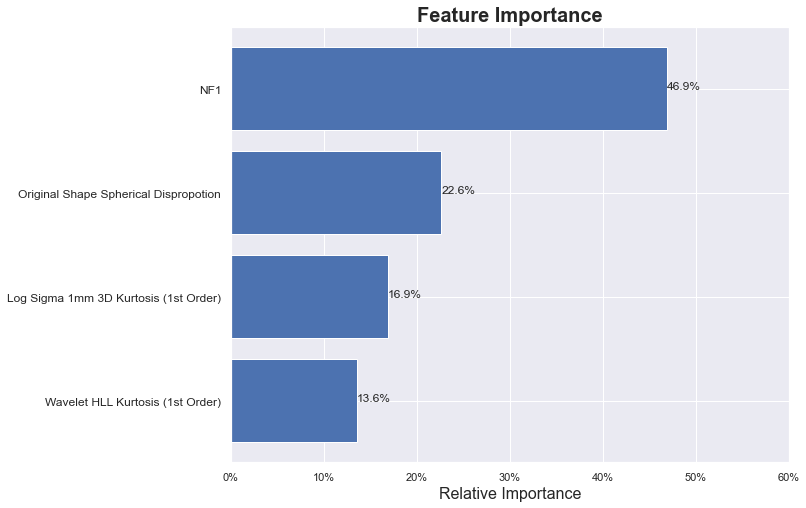

In [46]:
feature_names = X_test.columns.to_list()
importances = lr_model.coef_[0]
importances = np.abs(importances) / np.sum(np.abs(importances))

indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.6)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [47]:
sns.reset_orig()

# KNN

### Grid Search for Hyperparameters

In [48]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [49]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5]}, scoring='accuracy')

In [50]:
print(knn_grid.best_params_)

{'n_neighbors': 5}


### Model Performance

In [51]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [52]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.8333333333333334
Specificity Score: 0.7777777777777778
Precision: 0.9333333333333333
Recall: 0.8484848484848485
F1 Score: 0.888888888888889


In [53]:
knn_probs = knn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
auc = roc_auc_score(y_test, knn_probs)
print("AUC: " + str(auc))

AUC: 0.9242424242424243


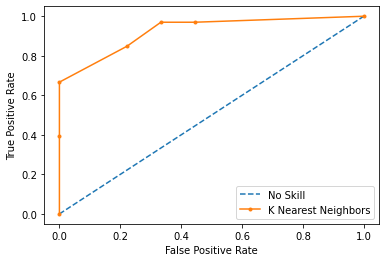

In [54]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='K Nearest Neighbors')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

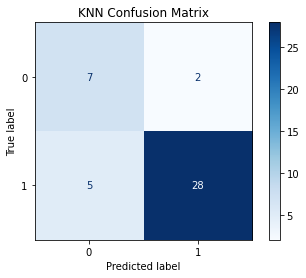

In [55]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

In [56]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(knn_probs), len(knn_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], knn_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [57]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.828 - 0.988]
95% Confidence interval for the Accuracy score: [0.714 - 0.929]
95% Confidence interval for the Specificity score: [0.444 - 1.0]
95% Confidence interval for the Precision score: [0.828 - 1.0]
95% Confidence interval for the Recall score: [0.719 - 0.968]
95% Confidence interval for the F1 score: [0.793 - 0.959]


# Random Forest

### Grid Search for Hyperparameters
 

In [58]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [59]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [60]:
print(rf_grid.best_params_)

{'max_depth': 1, 'n_estimators': 50}


### Model Performance

In [61]:
rf_model = RandomForestClassifier(max_depth = 1, n_estimators = 50, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [62]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.9047619047619048
Specificity Score: 0.6666666666666666
Precision: 0.9142857142857143
Recall: 0.9696969696969697
F1 Score: 0.9411764705882354


In [63]:
rf_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
auc = roc_auc_score(y_test, rf_probs)
print("AUC: " + str(auc))

AUC: 0.8720538720538721


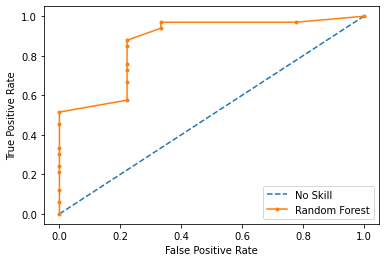

In [64]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

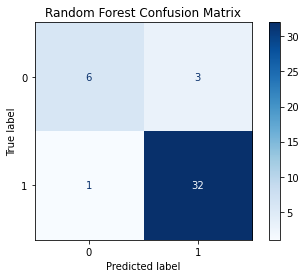

In [65]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

In [66]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(rf_probs), len(rf_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], rf_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [67]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.719 - 0.987]
95% Confidence interval for the Accuracy score: [0.810 - 0.976]
95% Confidence interval for the Specificity score: [0.333 - 1.0]
95% Confidence interval for the Precision score: [0.812 - 1.0]
95% Confidence interval for the Recall score: [0.900 - 1.0]
95% Confidence interval for the F1 score: [0.873 - 0.986]


In [92]:
sns.set()

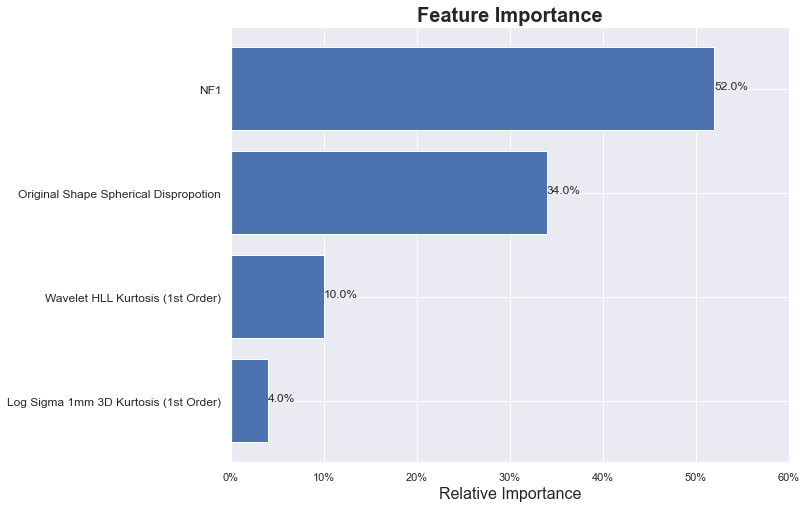

In [93]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.6)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [94]:
sns.reset_orig()

# XGBoost

### Grid Search for Hyperparameters

In [69]:
xgb_model = XGBClassifier(random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [70]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [71]:
print(xgb_grid.best_params_)

{'learning_rate': 0.2, 'max_depth': 4}


### Model Performance

In [72]:
xgb_model = XGBClassifier(learning_rate = 0.2, max_depth = 4, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [73]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.7857142857142857
Specificity Score: 0.6666666666666666
Precision: 0.9
Recall: 0.8181818181818182
F1 Score: 0.8571428571428572


In [74]:
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
auc = roc_auc_score(y_test, xgb_probs)
print("AUC: " + str(auc))

AUC: 0.7811447811447811


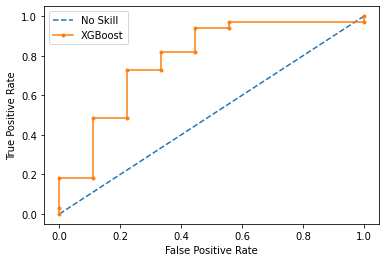

In [75]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

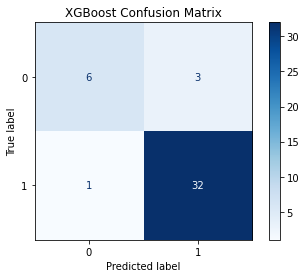

In [76]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

In [77]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(xgb_probs), len(xgb_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], xgb_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [78]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.569 - 0.951]
95% Confidence interval for the Accuracy score: [0.667 - 0.905]
95% Confidence interval for the Specificity score: [0.333 - 1.0]
95% Confidence interval for the Precision score: [0.778 - 1.0]
95% Confidence interval for the Recall score: [0.677 - 0.939]
95% Confidence interval for the F1 score: [0.750 - 0.939]


In [79]:
sns.set()

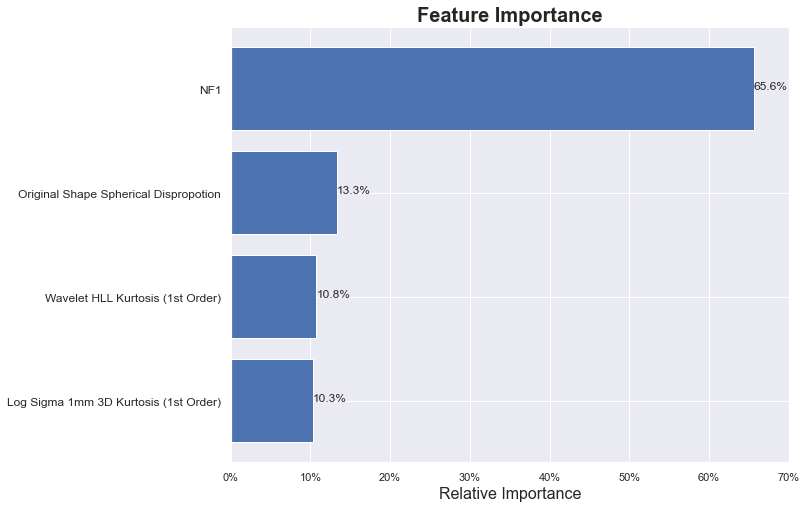

In [80]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importance',fontsize=20, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.7)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, "{:.1%}".format(value), fontsize=12)
plt.yticks(range(len(indices)), [feature_labels_dict[feature_names[i]] for i in indices],fontsize=12)
plt.xlabel('Relative Importance',fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()

In [81]:
sns.reset_orig()

# Neural Net

### Grid Search for Hyperparameters

In [82]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [83]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [84]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


### Model Performance

In [85]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 50, 100), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [86]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Specificity Score: " + str(specificity_score(y_test.to_numpy(), y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.8095238095238095
Specificity Score: 0.8888888888888888
Precision: 0.9629629629629629
Recall: 0.7878787878787878
F1 Score: 0.8666666666666665


In [87]:
nn_probs = nn_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, nn_probs)
auc = roc_auc_score(y_test, nn_probs)
print("AUC: " + str(auc))

AUC: 0.9393939393939394


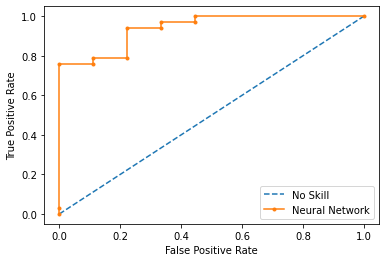

In [88]:
ns_preds = [0 for _ in range(len(y_test))]

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

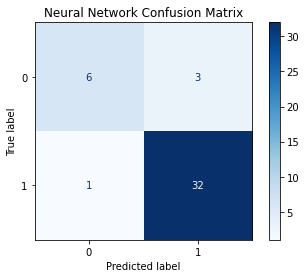

In [89]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

In [90]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f1_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(nn_probs), len(nn_probs))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    auc_score = roc_auc_score(y_test.to_numpy()[indices], nn_probs[indices])
    acc_score = accuracy_score(y_test.to_numpy()[indices], y_pred[indices])
    spec_score = specificity_score(y_test.to_numpy()[indices], y_pred[indices])
    prec_score = precision_score(y_test.to_numpy()[indices], y_pred[indices])
    rec_score = recall_score(y_test.to_numpy()[indices], y_pred[indices])
    f_one_score = f1_score(y_test.to_numpy()[indices].astype('float64'), y_pred[indices].astype('float64'))

    bootstrapped_auc_scores.append(auc_score)
    bootstrapped_acc_scores.append(acc_score)
    bootstrapped_spec_scores.append(spec_score)
    bootstrapped_prec_scores.append(prec_score)
    bootstrapped_rec_scores.append(rec_score)
    bootstrapped_f1_scores.append(f_one_score)

In [91]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f1_scores, "F1")

95% Confidence interval for the AUC score: [0.845 - 1.0]
95% Confidence interval for the Accuracy score: [0.690 - 0.929]
95% Confidence interval for the Specificity score: [0.615 - 1.0]
95% Confidence interval for the Precision score: [0.875 - 1.0]
95% Confidence interval for the Recall score: [0.633 - 0.914]
95% Confidence interval for the F1 score: [0.756 - 0.947]
